In [77]:
import os
import sys
import re
import math
import itertools

import scipy
import pandas as pd
import numpy as np

from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

import spacy
import fasttext
import pkg_resources

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
gloveFile = "glove.6B.50d.txt"

# Code from Papers

### Transformer Paper



yelp_acc_path = 'acc_yelp.bin'
yelp_ppl_path = 'ppl_yelp.binary'
yelp_ref0_path = 'yelp.refs.0'
yelp_ref1_path = 'yelp.refs.1'


yelp_acc_file = pkg_resources.resource_stream(resource_package, yelp_acc_path)
yelp_ppl_file = pkg_resources.resource_stream(resource_package, yelp_ppl_path)
yelp_ref0_file = pkg_resources.resource_stream(resource_package, yelp_ref0_path)
yelp_ref1_file = pkg_resources.resource_stream(resource_package, yelp_ref1_path)


self.yelp_ref = []
with open(yelp_ref0_file.name, 'r') as fin:
    self.yelp_ref.append(fin.readlines())
with open(yelp_ref1_file.name, 'r') as fin:
    self.yelp_ref.append(fin.readlines())
self.classifier_yelp = fasttext.load_model(yelp_acc_file.name)
self.yelp_ppl_model = kenlm.Model(yelp_ppl_file.name)

In [ ]:
# Style check from fastText model

def yelp_style_check(self, text_transfered, style_origin):
        text_transfered = ' '.join(word_tokenize(text_transfered.lower().strip()))
        if text_transfered == '':
            return False
        label = self.classifier_yelp.predict([text_transfered])
        style_transfered = label[0][0] == '__label__positive'
        return (style_transfered != style_origin)
    
# Checking the accuracy for different styles
    
def yelp_acc_b(self, texts, styles_origin):
        assert len(texts) == len(styles_origin), 'Size of inputs does not match!'
        count = 0
        for text, style in zip(texts, styles_origin):
            if self.yelp_style_check(text, style):
                count += 1
        return count / len(texts)

def yelp_acc_0(self, texts):
        styles_origin = [0] * len(texts)
        return self.yelp_acc_b(texts, styles_origin)

def yelp_acc_1(self, texts):
        styles_origin = [1] * len(texts)
        return self.yelp_acc_b(texts, styles_origin)

In [40]:
# Initialize the NLTK model
def nltk_bleu(texts_origin, text_transfered):
        texts_origin = [word_tokenize(text_origin.lower().strip()) for text_origin in texts_origin]
        text_transfered = word_tokenize(text_transfered.lower().strip())
        return sentence_bleu(texts_origin, text_transfered) * 100

# Check the BLEU diff between original & transferred text
def self_bleu_b(self, texts_origin, texts_transfered):
        assert len(texts_origin) == len(texts_transfered), 'Size of inputs does not match!'
        sum = 0
        n = len(texts_origin)
        for x, y in zip(texts_origin, texts_transfered):
            sum += self.nltk_bleu([x], y)
        return sum / n

In [ ]:
# Measures perplexity of language model

def yelp_ppl(self, texts_transfered):
        texts_transfered = [' '.join(word_tokenize(itm.lower().strip())) for itm in texts_transfered]
        sum = 0
        words = []
        length = 0
        for i, line in enumerate(texts_transfered):
            words += [word for word in line.split()]
            length += len(line.split())
            score = self.yelp_ppl_model.score(line)
            sum += score
        return math.pow(10, -sum / length)

### ARAE

In [ ]:

def train_ngram_lm(kenlm_path, data_path, output_path, N):
    """
    Trains a modified Kneser-Ney n-gram KenLM from a text file.
    Creates a .arpa file to store n-grams.
    """
    # create .arpa file of n-grams
    curdir = os.path.abspath(os.path.curdir)
    #
    command = "bin/lmplz -o "+str(N)+" <"+os.path.join(curdir, data_path) + \
              " >"+os.path.join(curdir, output_path)
    os.system("cd "+os.path.join(kenlm_path, 'build')+" && "+command)

    load_kenlm()
    # create language model
    assert(output_path)  # captured by try..except block outside
    model = kenlm.Model(output_path)

    return model


def get_ppl(lm, sentences):
    """
    Assume sentences is a list of strings (space delimited sentences)
    """
    total_nll = 0
    total_wc = 0
    for sent in sentences:
        words = sent.strip().split()
        nll = np.sum([- math.log(math.pow(10.0, score)) for score, _, _ in lm.full_scores(sent, bos=True, eos=False)])
        word_count = len(words)
        total_wc += word_count
        total_nll += nll
    ppl = np.exp(total_nll / total_wc)
    return ppl


### Other

In [3]:
def cosine_distance_countvectorizer_method(s1, s2):
    
    # sentences to list
    allsentences = [s1 , s2]
    
    # packages
    from sklearn.feature_extraction.text import CountVectorizer
    from scipy.spatial import distance
    
    # text to vector
    vectorizer = CountVectorizer()
    all_sentences_to_vector = vectorizer.fit_transform(allsentences)
    text_to_vector_v1 = all_sentences_to_vector.toarray()[0].tolist()
    text_to_vector_v2 = all_sentences_to_vector.toarray()[1].tolist()
    
    # distance of similarity
    cosine = distance.cosine(text_to_vector_v1, text_to_vector_v2)
    print('Similarity of two sentences are equal to ',round((1-cosine)*100,2),'%')
    return cosine

In [4]:


def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    with open(gloveFile, encoding="utf8" ) as f:
        content = f.readlines()
    model = {}
    for line in content:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model


def preprocess(raw_text):

    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split 
    words = letters_only_text.lower().split()

    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    cleaned_words = list(set([w for w in words if w not in stopword_set]))

    return cleaned_words

def cosine_distance_between_two_words(word1, word2):
    import scipy
    return (1- scipy.spatial.distance.cosine(model[word1], model[word2]))

def calculate_heat_matrix_for_two_sentences(s1,s2):
    s1 = preprocess(s1)
    s2 = preprocess(s2)
    result_list = [[cosine_distance_between_two_words(word1, word2) for word2 in s2] for word1 in s1]
    result_df = pd.DataFrame(result_list)
    result_df.columns = s2
    result_df.index = s1
    return result_df

def cosine_distance_wordembedding_method(s1, s2):
    import scipy
    vector_1 = np.mean([model[word] for word in preprocess(s1)],axis=0)
    vector_2 = np.mean([model[word] for word in preprocess(s2)],axis=0)
    cosine = scipy.spatial.distance.cosine(vector_1, vector_2)
    print('Word Embedding method with a cosine distance asses that our two sentences are similar to',round((1-cosine)*100,2),'%')

def heat_map_matrix_between_two_sentences(s1,s2):
    df = calculate_heat_matrix_for_two_sentences(s1,s2)
    import seaborn as sns
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(5,5)) 
    ax_blue = sns.heatmap(df, cmap="YlGnBu")
    # ax_red = sns.heatmap(df)
    print(cosine_distance_wordembedding_method(s1, s2))
    return ax_blue

Word Embedding method with a cosine distance asses that our two sentences are similar to 98.39 %
None


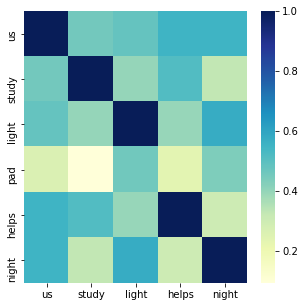

In [13]:
heat_map_matrix_between_two_sentences(gold[100],raw0[100])

# Our Code

In [9]:
path = "/home/ubuntu/style-transformer/outputs/soph/model_iteration_lr_0.0001/"
with open(path + "gold_text.txt") as f:
    gold = f.readlines()
    
with open(path + "rev_output_0.txt") as f:
    rev0 = f.readlines()
    
with open(path + "raw_output_0.txt") as f:
    raw0 = f.readlines()

In [25]:
def process(sent):
    sent = sent.strip().replace('<pad>', '').strip()
    return sent

In [26]:
gold = list(map(process, gold))
rev0 = list(map(process, rev0))
raw0 = list(map(process, raw0))

### Bleu

In [112]:
def bleu_sent(originText, transferredText):
        texts_origin = [
            word_tokenize(text.lower().strip()) 
            for text in originText
        ]
        text_transfered = word_tokenize(transferredText.lower().strip())
        return sentence_bleu(texts_origin, text_transfered) * 100
    


def bleu_avg(originText, transferredText):
        assert len(originText) == len(transferredText), 'Size of inputs does not match!'
        sum = 0
        n = len(originText)
        for x, y in zip(originText, transferredText):
            sum += bleu_sent([x], y)
        return sum / n

In [49]:
self_bleu_b(gold, raw0)

83.02805322367601

### KenLM

In [117]:
def load_kenlm():
    global kenlm
    import kenlm

def train_ngram_lm(kenlm_path, data_path, output_path, N, load=False):
    """
    FROM ARAE
    Trains a modified Kneser-Ney n-gram KenLM from a text file.
    Creates a .arpa file to store n-grams.
    """
    if not load:
        
        curdir = os.path.abspath(os.path.curdir)
        command = "bin/lmplz -o "+str(N)+" <"+os.path.join(curdir, data_path) + \
                  " >"+os.path.join(curdir, output_path)
        print(command)
        os.system("cd "+os.path.join(kenlm_path, 'build')+" && "+command)

    load_kenlm()

    assert(output_path) 
    model = kenlm.Model(output_path)

    return model

In [20]:
kenlm_model = train_ngram_lm('kenlm', 'data/processed/allsophs.txt', '5gram_model.arpa', 5)

bin/lmplz -o 5 </home/ubuntu/CS_230_Project/data/processed/allsophs.txt >/home/ubuntu/CS_230_Project/5gram_model.arpa


In [22]:

print(kenlm_model.score(gold[0]))
print(kenlm_model.score(raw0[0]))

-17.408981323242188
-9.268087387084961


In [27]:
sentence = gold[10]
# Show scores and n-gram matches
words = ['<s>'] + sentence.split() + ['</s>']
for i, (prob, length, oov) in enumerate(kenlm_model.full_scores(sentence)):
    print('{0} {1}: {2}'.format(prob, length, ' '.join(words[i+2-length:i+2])))
    if oov:
        print('\t"{0}" is an OOV'.format(words[i+1]))

# Find out-of-vocabulary words
for w in words:
    if not w in kenlm_model:
        print('"{0}" is an OOV'.format(w))

-1.7872710227966309 2: <s> they
-4.943023204803467 1: follow
-2.9482524394989014 1: what
-6.129945755004883 1: technology
	"technology" is an OOV
-1.8631486892700195 1: to
-1.8545496463775635 2: to make
-3.6443941593170166 2: make life
-5.866559028625488 1: .
-0.6411341428756714 2: . </s>
"technology" is an OOV


In [28]:
def get_ppl(lm, sentences):
    """
    Assume sentences is a list of strings (space delimited sentences)
    """
    total_nll = 0
    total_wc = 0
    for sent in sentences:
        words = sent.strip().split()
        nll = np.sum([- math.log(math.pow(10.0, score)) for score, _, _ in lm.full_scores(sent, bos=True, eos=False)])
        word_count = len(words)
        total_wc += word_count
        total_nll += nll
    ppl = np.exp(total_nll / total_wc)
    return ppl

In [29]:
get_ppl(kenlm_model, gold)


720.2415806656699

In [30]:
get_ppl(kenlm_model, raw0)


969.148919193934

In [31]:
get_ppl(kenlm_model, rev0)


1047.93716841179

### Similarities - Jaccard,  Cosine

In [65]:
def jaccard_sim(sent1, sent2): 
    a = set(sent1.split()) 
    b = set(sent2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [72]:
jaccard_sim(gold[0], rev0[0])

0.6

In [53]:

def loadGloveModel(gloveFile):
    with open(gloveFile, encoding="utf8" ) as f:
        content = f.readlines()
    model = {}
    for line in content:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    return model


def cosine_format(raw):

    processed = re.sub("[^a-zA-Z]", " ", raw)
    words = processed.lower().split()
    stopword_set = set(stopwords.words("english"))
    uniq_words = list(set([w for w in words if w not in stopword_set]))
    
    return uniq_words

def cosine_words(word1, word2):

    return cosine_similarity(model[word1], model[word2])


In [50]:
model = loadGloveModel(gloveFile)

In [94]:
def cosine_sent(sent1, sent2):
    if not isinstance(sent1, list):
        sent1 = cosine_format(sent1)
        sent2 = cosine_format(sent2)

    embs1 = np.mean([model[word] for word in sent1], axis=0)
    embs2 = np.mean([model[word] for word in sent2], axis=0)

    return(1 - scipy.spatial.distance.cosine(embs1, embs2))

In [100]:
cosine_sent(gold[106], rev0[106])

0.9578221528266511

In [107]:

def heat_matrix(sent1, sent2):
    
    s1 = cosine_format(sent1)
    s2 = cosine_format(sent2)
    
    result_list = [[cosine_words(word1, word2) for word2 in s2] for word1 in s1]
    result_df = pd.DataFrame(result_list)
    result_df.columns = s2
    result_df.index = s1
    
    return result_df


def heat_map(s1,s2):
    df = heat_matrix(s1, s2)

    fig, ax = plt.subplots(figsize=(5,5)) 
    ax_blue = sns.heatmap(df, cmap="YlGnBu")
    print(cosine_sent(s1, s2))
    return ax_blue

1.0


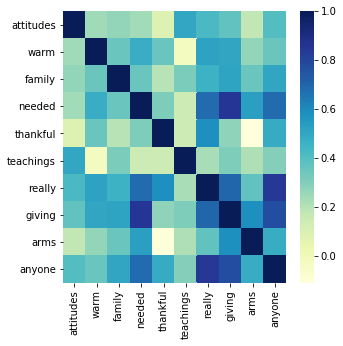

In [108]:
heat_map(gold[105], raw0[105])

### Putting it all together

In [115]:
def sentenceMetrics(sent1, sent2, plot=False):
    metrics = {}
    
    metrics['bleu'] = bleu_sent(sent1, sent2)
    metrics['cosine'] = cosine_sent(sent1, sent2)
    metrics['jaccard'] = jaccard_sim(sent1, sent2)
    
    if plot:
        heat_map(sent1, sent2)
    return metrics

0.6223309868675798


{'bleu': 0, 'cosine': 0.6223309868675798, 'jaccard': 0.6}

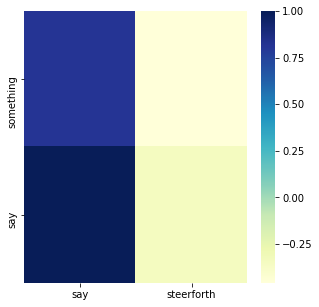

In [116]:
sentenceMetrics(gold[0], rev0[0], plot=True)

In [118]:
def globalMetrics(origData, transferData):
    metrics = {}
    
    metrics['bleu'] = bleu_avg(origData, transferData)
    metrics['ppl'] = (get_ppl(kenlm_model, origData), 
                      get_ppl(kenlm_model, transferData))
    
    return metrics

In [119]:
globalMetrics(gold, rev0)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it cont

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it cont

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it cont

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it cont

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it cont

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it cont

{'bleu': 41.74098695714708, 'ppl': (720.2415806656699, 1047.93716841179)}